In [23]:
import json
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, PowerTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor

import requests
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, boxcox_normmax, probplot

https://docs.uniswap.org/sdk/subgraph/subgraph-examples

In [24]:
url ='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

address = "0x1f9840a85d5af5bf1d1762f925bdaddc4201f984"

query = f"""
        {{token (id: "{address}"){{tokenDayData(first:1000, skip:2) {{ priceUSD date open close high low volume volumeUSD}} }} }}
        """

r = requests.post(url, json = {'query': query})
json_data = json.loads(r.text)

In [25]:
json_data

{'data': {'token': {'tokenDayData': [{'priceUSD': '40.04521108555178501820203021579761',
     'date': 1620259200,
     'open': '42.12956237680189064812944637693338',
     'close': '40.04521108555178501820203021579761',
     'high': '42.4795195194498923800489395513399',
     'low': '39.77017755925643513470958183129897',
     'volume': '302689.433341461719498428',
     'volumeUSD': '12466870.03249654793909146013641258'},
    {'priceUSD': '39.66533204379280698242305400483144',
     'date': 1620345600,
     'open': '40.04548024586966758814719711377671',
     'close': '39.66533204379280698242305400483144',
     'high': '41.19374676859546904129348429739851',
     'low': '38.57450356698197954877744211326047',
     'volume': '236223.256941440371594041',
     'volumeUSD': '9418263.06508308484903299213675241'},
    {'priceUSD': '40.57203107661686548413275528522806',
     'date': 1620432000,
     'open': '39.66337607032013611831211854725878',
     'close': '40.57203107661686548413275528522806',
 

In [26]:
len(json_data['data']['token']['tokenDayData'])

528

In [27]:
df_data = json_data['data']['token']['tokenDayData']
df = pd.DataFrame(df_data)

In [28]:
df.to_csv("data.csv")

# EDA

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   priceUSD   528 non-null    object
 1   date       528 non-null    int64 
 2   open       528 non-null    object
 3   close      528 non-null    object
 4   high       528 non-null    object
 5   low        528 non-null    object
 6   volume     528 non-null    object
 7   volumeUSD  528 non-null    object
dtypes: int64(1), object(7)
memory usage: 33.1+ KB


In [30]:
columns = ['priceUSD', 'open', 'close', 'high', 'low', 'volume', 'volumeUSD']

for x in columns:
    df[x] = df[x].astype(float)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   priceUSD   528 non-null    float64
 1   date       528 non-null    int64  
 2   open       528 non-null    float64
 3   close      528 non-null    float64
 4   high       528 non-null    float64
 5   low        528 non-null    float64
 6   volume     528 non-null    float64
 7   volumeUSD  528 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 33.1 KB


In [32]:
df.describe()

,priceUSD,date,open,close,high,low,volume,volumeUSD
count,528.000000,5.280000e+02,528.000000,528.000000,528.000000,528.000000,5.280000e+02,5.280000e+02
mean,15.156872,1.643026e+09,15.228618,15.156872,15.872912,14.482301,4.871152e+05,7.547062e+06
std,8.680325,1.318159e+07,8.751225,8.680325,9.148594,8.295027,4.112406e+05,9.265877e+06
min,3.645075,1.620259e+09,3.654224,3.645075,3.904146,3.249385,1.949339e+04,2.057296e+05
25%,7.085406,1.631642e+09,7.098987,7.085406,7.403177,6.796561,1.980322e+05,2.045283e+06
50%,11.902121,1.643026e+09,12.142814,11.902121,12.581980,11.556098,3.987190e+05,4.292056e+06
75%,22.513229,1.654409e+09,22.669115,22.513229,23.856092,21.410535,6.248607e+05,9.047539e+06
max,40.572031,1.665792e+09,42.129562,40.572031,43.846977,39.770178,2.401189e+06,6.138762e+07


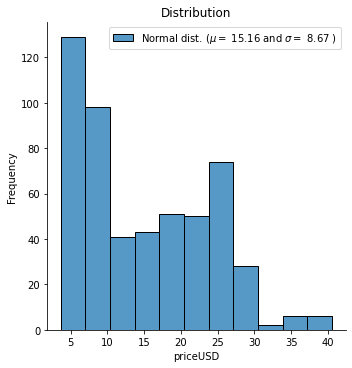

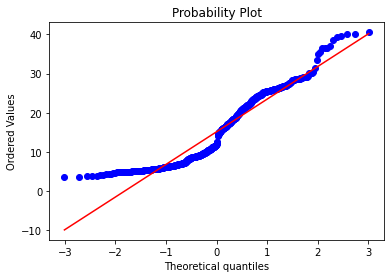

In [33]:
def plot_dist(var):
    sns.displot(var);
    (mu, sigma) = norm.fit(var)

    #plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution')

    #QQ-plot
    plt.figure()
    probplot(var, plot=plt)
    plt.show()

plot_dist(df['priceUSD'])

## Target value Transformation

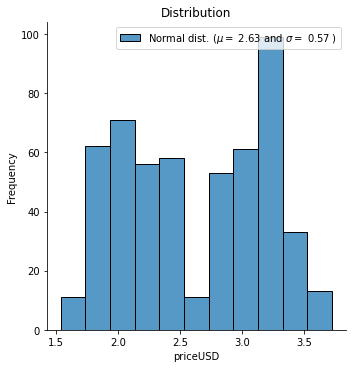

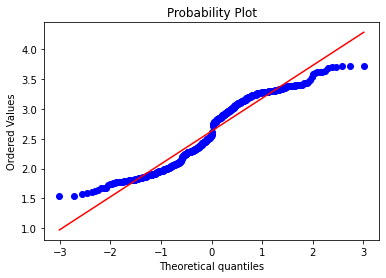

In [34]:
df["priceUSD"] = np.log1p(df["priceUSD"])
plot_dist(df['priceUSD'])

## Feature Engineering

In [35]:
df["utc"] = df.date.apply(lambda x: datetime.utcfromtimestamp(x))
df['day'] = df.utc.apply(lambda time: time.day)
df["weekday"] = df.utc.apply(lambda time: time.dayofweek)
df['month'] = df.utc.apply(lambda time: time.month)
df['year'] = df.utc.apply(lambda time: time.year).astype("category")

In [36]:
numericF = ['open', 'close', 'high', 'low', 'volume', 'volumeUSD', 'priceUSD']

for x in numericF:
    df[f"{x}-1"] = df[x].shift(1)
    df[f"{x}-2"] = df[x].shift(2)

In [37]:
numeric_feats = df.dtypes[(df.dtypes != "object") & (df.dtypes != 'category') & (df.dtypes!= 'datetime64[ns]')].index.tolist()

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna()))
print(skewed_feats)
sk = skewed_feats[abs(skewed_feats)>1].index.to_list()
df[sk] = np.log1p(df[sk])

priceUSD      -4.221660e-02
date          -1.113031e-16
open           5.747087e-01
close          5.552528e-01
high           5.886071e-01
low            5.741533e-01
volume         1.848051e+00
volumeUSD      2.774387e+00
day            3.238873e-02
weekday       -6.395599e-03
month         -1.833916e-01
open-1         5.720820e-01
open-2         5.695183e-01
close-1        5.526931e-01
close-2        5.500258e-01
high-1         5.861101e-01
high-2         5.835192e-01
low-1          5.715175e-01
low-2          5.688383e-01
volume-1       1.845010e+00
volume-2       1.850534e+00
volumeUSD-1    2.771777e+00
volumeUSD-2    2.768242e+00
priceUSD-1    -4.590806e-02
priceUSD-2    -4.972085e-02
dtype: float64


## Training

In [38]:
ceiling = int(len(df)*0.8)

In [39]:
train, test = df[2:ceiling], df[ceiling:]

In [40]:
numeric_features = [#'date', 
                    'weekday', 
                    'day', 
                    'month', 
                    'open-1', 
                    'close-1', 
                    'high-1', 
                    'low-1', 
                    'volume-1', 
                    'volumeUSD-1', 
                    'priceUSD-1',
                    'priceUSD-2',
                    'volume-2',
                    #'open-2', 'close-2', 'high-2', 'low-2', 
    #'volumeUSD-2'
                    ]

object_features = [ #'weekday'
    #"month"
    'year'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), object_features),
        ('num', RobustScaler() , numeric_features)
    ])

In [41]:
clf_xg = Pipeline(steps=[
                    ('pre', preprocessor),
                    ('poly', PolynomialFeatures(2)),
                    ('selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=150, random_state=1))),
                    ('a', MLPRegressor(random_state=1, max_iter=500, solver="adam", alpha=0.0001, early_stopping=False)),
                    ])

clf_xg.fit(train[numeric_features + object_features], train['priceUSD'])

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year']),
                                                 ('num', RobustScaler(),
                                                  ['weekday', 'day', 'month',
                                                   'open-1', 'close-1',
                                                   'high-1', 'low-1',
                                                   'volume-1', 'volumeUSD-1',
                                                   'priceUSD-1', 'priceUSD-2',
                                                   'volume-2'])])),
                ('poly', PolynomialFeatures()),
                ('selection',
                 SelectFromModel(estimator=RandomForestRegressor(n_estimators=150,
                                                                 random_state=1))),
                ('a', MLPRegressor(max_iter=500, random_state=1))])

In [42]:
predictions = clf_xg.predict(test[numeric_features + object_features])

In [43]:
mae = mean_absolute_error(np.expm1(test['priceUSD']), np.expm1(predictions), multioutput="raw_values")

In [44]:
mae

array([0.27202792])